In [245]:
import numpy as np 
import pandas as pd
import os
import cv2
import os
import re
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

Let's define a custom PyTorch dataset called TurbineDataset, which is intended for use in object detection tasks for working with turbine image data. 

In [187]:
class TurbineDataset(Dataset):
    """
    Custom PyTorch dataset for turbine image data.

    This dataset is designed for object detection tasks where each image contains
    annotations of turbine components. It can be used for both training and inference.

    Args:
        dataframe (pandas.DataFrame): The DataFrame containing image and annotation information.
        transforms (callable, optional): A function/transform to apply to the image data.
        train (bool, optional): Specify if the dataset is for training (True) or inference (False).

    Attributes:
        image_ids (numpy.ndarray): Unique image IDs extracted from the DataFrame.
        df (pandas.DataFrame): The input DataFrame containing image and annotation information.
        transforms (callable, optional): A function/transform for image data augmentation.
        train (bool): Indicates whether the dataset is for training (True) or inference (False).

    Methods:
        __len__(): Returns the number of unique images in the dataset.
        __getitem__(index): Retrieves an image and its associated annotations.

    For training:
    - Images are loaded and transformed.
    - Annotations are retrieved and organized into a dictionary.

    For inference:
    - Only images are loaded and returned.

    Returns:
        If 'train' is True:
            Tuple containing:
                - image (torch.Tensor): The preprocessed image.
                - target (dict): A dictionary containing annotations (boxes, labels, etc.).
                - image_id (str): ID of the image.
        If 'train' is False:
            Tuple containing:
                - image (torch.Tensor): The preprocessed image.
                - image_id (str): ID of the image.
    """
    def __init__(self, dataframe, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image'].unique()
        self.df = dataframe
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(image_id, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  
            image = self.transforms(image)
        if(self.train==False): 
            return image, image_id

        records = self.df[self.df['image'] == image_id]   
        boxes = records[['minx','miny', 'maxx', 'maxy']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)    
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        return image, target,image_id  

In [188]:
# Let's define an utility class for computing the average loss during training iterations.

class Averager:
    """
    A utility class for calculating and maintaining the average of a series of values.

    This class is typically used for computing the average loss during training iterations.

    Attributes:
        current_total (float): The running total of values to be averaged.
        iterations (float): The number of values added to the running total.

    Methods:
        send(value): Add a new value to the running total and update the number of iterations.
        value: Property that returns the average of the added values.
        reset(): Reset the running total and number of iterations to zero.

    Example Usage:
    ```
    avg_loss = Averager()
    avg_loss.send(2.0)
    avg_loss.send(3.0)
    average = avg_loss.value  # Returns 2.5
    avg_loss.reset()  # Resets the total and iterations to zero.
    ```

    Note:
        If no values are added (iterations = 0), the `value` property returns 0 to prevent division by zero.

    """
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        """
        Add a new value to the running total and update the number of iterations.

        Args:
            value (float): The value to be added to the running total.
        """
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        """
        Get the average value of the added values.

        Returns:
            float: The average value, or 0 if no values have been added (iterations = 0).
        """
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        """
        Reset the running total and number of iterations to zero.
        """
        self.current_total = 0.0
        self.iterations = 0.0

# Let's define a function for data loading in PyTorch's DataLoader. The following function takes a batch of individual data elements and arranges them into a tuple for further processing.
def collate_fn(batch):
    """
    Collates a batch of data elements into a structured format.

    This function is typically used in data loading pipelines, such as when working with
    PyTorch's DataLoader. It takes a batch of individual data elements and arranges them
    into a structured format, often as a tuple or a dictionary, making it suitable for
    further processing.

    Args:
        batch (list): A list of individual data elements to be collated.

    Returns:
        tuple: A tuple containing the collated data elements. The specific structure
        of the returned tuple may vary depending on the data and the application.

    Example Usage:
    ```
    batch = [(image1, label1), (image2, label2), (image3, label3)]
    collated_batch = collate_fn(batch)
    # Example collated_batch: ((image1, image2, image3), (label1, label2, label3))
    ```

    Note:
        The structure of the returned tuple should match the requirements of the downstream
        processing steps, such as model input.

    """
    return tuple(zip(*batch))


Let's define the transformation pipeline (trans) that converts image data into PyTorch tensors

In [189]:
trans = transforms.Compose([transforms.ToTensor()])

Let's split the dataset of unique images into multiple folds for cross-validation purposes, with each fold containing training and testing image sets.

In [190]:
selected_data = catalog.load('geodata_with_labels')

[11/14/23 15:07:41] INFO     Loading data from 'geodata_with_labels' (GenericDataset)...        ]8;id=6978;file:///home/persepolis/prj/fp/un-wind/un-wind/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=35906;file:///home/persepolis/prj/fp/un-wind/un-wind/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [191]:
selected_data

case_id   t_rd       xlong       ylat  t_hh  t_ttlh   t_cap   t_manu  \
63     3049503  125.0  -93.523651  42.006813  87.5   150.0  3000.0   Nordex   
64     3049500  125.0  -93.515892  42.016373  87.5   150.0  3000.0   Nordex   
65     3049504  125.0  -92.672089  41.742046  87.5   150.0  3000.0   Nordex   
66     3057059  125.0  -93.623009  41.881470  87.5   150.0  3000.0   Nordex   
70     3053390  125.0  -93.700424  41.977608  87.5   150.0  3000.0   Nordex   
...        ...    ...         ...        ...   ...     ...     ...      ...   
70251  3090584   47.0 -102.413589  30.953094  50.0    73.5   660.0   Gamesa   
70466  3013709   87.0  -95.654770  43.405952  78.0   121.6  2000.0   Gamesa   
70467  3013708   87.0  -95.657730  43.405960  78.0   121.6  2000.0   Gamesa   
70474  3042425   82.0  -76.967651  42.886246  70.0   110.9  1650.0  Hyundai   
70475  3042424   82.0  -76.968452  42.887146  70.0   110.9  1650.0  Hyundai   

          t_model  t_conf_atr  ...     cy  \
63     AW125/3000           3  ...  571.0   
64     AW125/3000           3  ...  867.0   
65     AW125/3000           3  ...  545.0   
66     AW125/3000           3  ...  505.0   
70     AW125/3000           3  ...  601.0   
...           ...         ...  ...    ...   
70251    G47-0.66           3  ...  368.0   
70466     G87-2.0           3  ...  540.0   
70467     G87-2.0           3  ...  539.0   
70474      HQ1650           3  ...  634.0   
70475      HQ1650           3  ...  534.0   

                                                     box   minx   miny   maxx  \
63     POLYGON ((-93.5228425162443 42.00741375335109,...  462.0  505.0  642.0   
64     POLYGON ((-93.51508351624429 42.01697366306611...  213.0  800.0  393.0   
65     POLYGON ((-92.6712805162443 41.74264924716535,...  482.0  478.0  662.0   
66     POLYGON ((-93.62220051624428 41.88207193554672...  472.0  438.0  652.0   
70     POLYGON ((-93.69961551624428 41.97820902906054...  481.0  534.0  661.0   
...                                                  ...    ...    ...    ...   
70251  POLYGON ((-102.41319284295972 30.9534337391799...  566.0  330.0  654.0   
70466  POLYGON ((-95.65411458916869 43.40642815625448...  476.0  487.0  622.0   
70467  POLYGON ((-95.6570745891687 43.4064361561916, ...  147.0  486.0  293.0   
70474  POLYGON ((-76.96705326100997 42.88668396556095...  566.0  586.0  699.0   
70475  POLYGON ((-76.96785426100993 42.88758395917108...  477.0  485.0  610.0   

        maxy            image_file cluster  polycount  overlaps  
63     638.0  naip_2635_IA_WND.tif     716          1     False  
64     934.0  naip_2632_IA_WND.tif     717          1     False  
65     612.0  naip_2693_IA_WND.tif     710          1     False  
66     572.0  naip_2615_IA_WND.tif     713          1     False  
70     667.0  naip_2617_IA_WND.tif     714          1     False  
...      ...                   ...     ...        ...       ...  
70251  406.0  naip_7732_TX_WND.tif     393          1     False  
70466  593.0  naip_2587_IA_WND.tif     587          1     False  
70467  592.0  naip_2587_IA_WND.tif     588          1     False  
70474  683.0  naip_6333_NY_WND.tif     816          1     False  
70475  583.0  naip_6333_NY_WND.tif     817          1     False  

[796 rows x 26 columns]

In [192]:
unique_images = selected_data['image'].unique()
unique_images = np.array(unique_images)
len(unique_images)
kf = KFold(n_splits=6)
folds = {}
for n, (train_index , test_index) in enumerate(kf.split(unique_images)):
    X_train , X_test = unique_images[train_index],unique_images[test_index]
    folds[n] = {}
    folds[n]['train']  = X_train
    folds[n]['test'] = X_test

Selecting one of the folds

In [193]:
fold  = 0
train_df = selected_data[selected_data['image'].isin(folds[fold]['train'])]
test_df = selected_data[selected_data['image'].isin(folds[fold]['test'])]

We define now two data loaders, train_data_loader and test_data_loader, to facilitate the training and testing of the ml model. The data loaders organize our training and testing data into batches and can be further customized for data shuffling and parallel data loading. 

In [194]:
train_dataset = TurbineDataset(train_df, trans,True)
test_dataset = TurbineDataset(test_df, trans,True)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

Selecting the appropriate device for running PyTorch operations. 

In [195]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

then we can visualize and example for a visual check:

[11/14/23 15:07:57] WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=172559;file:///home/persepolis/prj/fp/un-wind/un-wind/lib/python3.9/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=646764;file:///home/persepolis/prj/fp/un-wind/un-wind/lib/python3.9/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

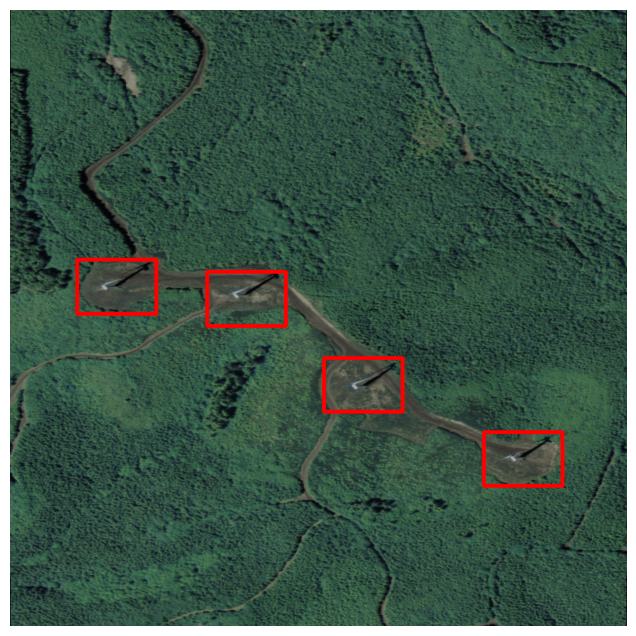

In [196]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[6]['boxes'].cpu().numpy().astype(np.int32)
sample = images[6].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    sample = cv2.rectangle(sample.copy() ,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 5)
    
ax.set_axis_off()
ax.imshow(sample)

In [197]:
example_image = images[6]

We load now a pre-trained Faster R-CNN model and customize it to detect __two classes: turbine and background.__ It then sets the model to evaluation mode.

### Faster R-CNN 

The Faster R-CNN object detection system consists of two modules: a Region Proposal Network (RPN) and the Fast R-CNN detector. The RPN proposes regions, guiding the Fast R-CNN on where to look. The network shares convolutional layers for efficient computation. The RPN uses a fully convolutional network to generate region proposals by sliding over the feature map. It predicts multiple region proposals simultaneously, each associated with an objectness score. The method ensures translation invariance for anchors and functions, reducing the model size. 

In details these are the blocks in the imported architecture:

#### Transform (GeneralizedRCNNTransform) 
This part of the model is responsible for preprocessing the input images. It includes normalization of pixel values and resizing the images to a specific size.

#### Backbone (BackboneWithFPN):
The backbone is the main feature extraction network. It's a deep neural network that takes in the preprocessed image and extracts hierarchical features. In this case, it's a ResNet-based backbone with a feature pyramid network (FPN) added on top.
- _ResNet Backbone:_ [Residual Network](https://en.wikipedia.org/wiki/Residual_neural_network)  is a type of neural network architecture that addresses the vanishing gradient problem in deep networks. It consists of multiple blocks, and each block has residual connections.
- _FPN [Feature Pyramid Network](https://arxiv.org/pdf/1612.03144.pdf) (FeaturePyramidNetwork):_ FPN enhances the backbone network by adding a top-down architecture with lateral connections to build a feature pyramid from the high-level semantic features.    he method is fully convolutional, taking a single-scale image and producing proportionally sized feature maps. The pyramid construction involves a bottom-up pathway using the backbone and a top-down pathway hallucinating higher resolution features, and lateral connections enhancing and merging features. The resulting pyramid shares classifiers and regressors, maintaining a consistent feature dimension. 
<br>
<br>
#### Region Proposal Network (RegionProposalNetwork):
This component proposes candidate object regions for further processing. It uses anchor boxes at different scales and aspect ratios to generate region proposals. The RPN predicts whether there is an object in each region (classification) and refines the bounding box coordinates.

#### Region of Interest Heads (RoIHeads):
RoI heads take the region proposals generated by the RPN and perform further processing to classify and refine the bounding boxes.

- _MultiScale RoIAlign:_ It aligns the features within the region of interest at multiple scales, providing more accurate and robust feature extraction.

- _Two MLP Head:_ The box head is a Multi-Layer Perceptron (MLP) that further processes the features from RoIAlign.
    
- _Fast R-CNN Predictor:_ The box predictor is another MLP that produces the final class scores and bounding box coordinates for each region of interest.



In summary, Faster R-CNN is a two-stage object detection model. The first stage proposes regions likely to contain objects using the region proposal network, and the second stage classifies and refines these proposals to obtain the final detection results. The backbone, Feature Pyramid Netwok, and Region of Interest heads play crucial roles in feature extraction, region proposal, and final detection.

It is an enhancement of the original model, where the "R-CNN" part stands for Region-Based Convolutional Neural Network. It worked by first proposing potential regions in an image where objects might be located, then using a Convolutional Neural Network (CNN) to classify and refine these proposed regions.

The key improvement in the Faster R-CNN is the integration of a Region Proposal Network (RPN), which efficiently proposes regions for objects in an image. This eliminates the need for external methods to propose regions, making the entire process faster and more streamlined.



The Faster R-CNN typically uses a pre-trained deep neural network as its backbone. In the case of our choiche we are loading FasterRCNN_ResNet50, that uses a [ResNet-based](https://en.wikipedia.org/wiki/Residual_neural_network) backbone, specifically [ResNet-50](https://arxiv.org/pdf/1512.03385.pdf). This backbone extracts hierarchical features from the input image. Then the Region Proposal Network RPN takes the feature maps from the backbone network and proposes potential regions in the image where objects might be present. It does this by sliding a small network (usually a 3x3 convolutional layer) over the spatial grid of the features. The RPN predicts whether there is an object at each anchor box and refines the box coordinates  After obtaining features from the backbone, the Feature Pyramid Network is used to generate feature pyramids. It enhances the model's ability to detect objects at different scales, helping it handle both small and large objects in the image. RoI (Region of Interest) Heads are then responsible for processing the proposed regions and making predictions. It consists of two main parts:
-  Box RoI Pooling: It pools the features inside each proposed region into a fixed-size feature map.
- Box Head: This part further processes the features through fully connected layers.
Region Proposal Network (RPN): This network proposes regions, and its output is used to create Region of Interest (RoI) proposals. ("Image passes through CNN and get feature map. For each position in the feature map, you have anchor boxes and every anchor box has two possible outcomes - foreground and background.)
RoI Heads: After getting RoI proposals, the RoI Heads perform classification and regression to determine the class and refine the bounding box for each proposed region.

In [246]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
num_classes = 2  # 1 class (turbine) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


enabling dropout and batch normalization layers

In [44]:
model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

In [60]:
for fold in folds.keys():
    print(fold)
    train_df = selected_data[selected_data['image'].isin(folds[fold]['train'])]
    test_df = selected_data[selected_data['image'].isin(folds[fold]['test'])]
    train_dataset = TurbineDataset(train_df, trans,True)
    test_dataset = TurbineDataset(test_df, trans,True)


    # split the dataset in train and test set
    indices = torch.randperm(len(train_dataset)).tolist()

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    num_classes = 2  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.eval()
    model.to(device)
    model.train()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    #lr_scheduler = None

    num_epochs = 5

    loss_hist = Averager()
    itr = 1

    for epoch in range(num_epochs):
        loss_hist.reset()

        for images, targets, image_ids in train_data_loader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)   ##Return the loss

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)  #Average out the loss

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}")
    torch.save(model, f'./outputs/wind_turbine_detector_fold_{str(fold)}.model')

0
Epoch #0 loss: 0.6589542329311371
Epoch #1 loss: 0.46183881689520445
Iteration #50 loss: 0.34029603004455566
Epoch #2 loss: 0.3750101222711451
Epoch #3 loss: 0.3542413501178517
Epoch #4 loss: 0.3342266485971563
1
Epoch #0 loss: 0.6032195862601785
Epoch #1 loss: 0.4343895947231966
Iteration #50 loss: 0.3222174644470215
Epoch #2 loss: 0.35849740925957174
Epoch #3 loss: 0.33880113678819995
Epoch #4 loss: 0.32190121622646556
2
Epoch #0 loss: 0.576164161457735
Epoch #1 loss: 0.3970663740354426
Iteration #50 loss: 0.31988176703453064
Epoch #2 loss: 0.33923768821884603
Epoch #3 loss: 0.3092420469312107
Epoch #4 loss: 0.29882180077188153
3
Epoch #0 loss: 0.6418917669969446
Epoch #1 loss: 0.43611902524443236
Iteration #50 loss: 0.34245771169662476
Epoch #2 loss: 0.3755528786603142
Epoch #3 loss: 0.3331407326109269
Epoch #4 loss: 0.3226975088610369
4
Epoch #0 loss: 0.5796971058144289
Epoch #1 loss: 0.43809721925679374
Iteration #50 loss: 0.32755404710769653
Epoch #2 loss: 0.3539150339715621
Ep

In [246]:
import dill as pickle

In [247]:
filehandler = open('./outputs/train_data_loader.pickle.', 'wb') 
pickle.dump(train_data_loader, filehandler)

In [248]:
filehandler = open('./outputs/test_data_loader.pickle', 'wb') 
pickle.dump(test_data_loader, filehandler)

# CREATING IMAGES FOR README

In [199]:
model = torch.load('./outputs/wind_turbine_detector_fold_0.model')

In [200]:
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

In [201]:
for images_batch, targets, image_ids in tqdm(test_data_loader):
    images = list(image.to(device) for image in images_batch)
    outputs = model(images)
    break

  0%|          | 0/7 [00:00<?, ?it/s]

In [202]:
data_iter = iter(test_data_loader)

# Get the first batch
first_batch = next(data_iter)

In [203]:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
image_ids = first_batch[2]

In [220]:
def plot_image_with_results(image, targets=None, image_id=None):
    sample = image.permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    if targets is not None:
        boxes = target['boxes'].cpu().numpy().astype(np.int32)
        for box in boxes:
            sample = cv2.rectangle(sample.copy(),
                                   (box[0], box[1]),
                                   (box[2], box[3]),
                                   (220, 0, 0), 5)
    if image_id is not None:
        print(image_id)
    ax.set_axis_off()
    ax.imshow(sample)
    plt.savefig(f'image.png')

def print_layer(layers, layer):
    #output_tensor = layers[layer]
    
    # Convert the output tensor to a numpy array
    output_array = layers[layer][0].cpu().detach().numpy()
    print(output_array.shape)
    size = output_array.shape[2] /30
    fig, ax = plt.subplots(1, 1, figsize=(size, size))

    # Visualize the output (assuming a 3-channel image)
    ax.imshow(output_array[0, 0, :, :], cmap='viridis')
    ax.set_axis_off()
    plt.savefig(f'saved_fig_{layer}.png')



In [221]:
outputs = {}
for idx, image in enumerate(images):
    
    outputs[idx] = {}
    outputs[idx]['image'] = image    
    target = targets[idx]
    outputs[idx]['targets'] = target
    image_id = image_ids[idx]
    outputs[idx]['image_id'] = image_id
    
    
    layers_output = {}
    # Define the hook function to get the output of layer 
    def hook_fn(module, input, output, layer=1):
        if layer in layers_output:
            layers_output[layer].append(output)
        else:
            layers_output[layer] = [output]
    # Register the hook to the desired layer
    hook1 = model.backbone.body.layer1.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=1))
    hook2 = model.backbone.body.layer2.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=2))
    hook3 = model.backbone.body.layer3.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=3))
    hook4 = model.backbone.body.layer4.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=4))
    # Inner blocks these are the 1x1 convolutions applied to the feature maps at different stages of the backbone.
    hook_p2 = model.backbone.fpn.inner_blocks[0].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P2'))
    hook_p3 = model.backbone.fpn.inner_blocks[1].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P3'))
    hook_p4 = model.backbone.fpn.inner_blocks[2].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P4'))
    hook_p4 = model.backbone.fpn.inner_blocks[3].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P5'))
    # These are the 3x3 convolutions applied to merge feature maps from the bottom-up pathway and the top-down pathway.
    hook_M5 = model.backbone.fpn.layer_blocks[0].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M5'))
    hook_M4 = model.backbone.fpn.layer_blocks[1].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M4'))
    hook_M3 = model.backbone.fpn.layer_blocks[2].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M3'))
    hook_M2 = model.backbone.fpn.layer_blocks[3].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M2'))
    hook_RPN_cls_logits = model.rpn.head.cls_logits.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_cls_logits'))
    hook_RPN_bbox_pred = model.rpn.head.bbox_pred.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_bbox_pred'))
    hook_RPN_conv = model.rpn.head.conv.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_conv'))
    hook_RPN_conv_input = model.rpn.head.conv.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_conv_input'))

    hook_RPN_anchor = model.rpn.anchor_generator.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_anchor'))
    # Forward pass through the model
    output_list = model(image.unsqueeze(0))
    # Remove the hook to avoid interference with future forward passes
    hook1.remove()
    hook2.remove()
    hook3.remove()
    hook4.remove()
    hook_p2.remove()
    hook_p3.remove()
    hook_p4.remove()
    hook_M5.remove()
    hook_M4.remove()
    hook_M3.remove()
    hook_M2.remove()
    hook_RPN_cls_logits.remove()
    hook_RPN_bbox_pred.remove()
    hook_RPN_conv.remove()
    hook_RPN_conv_input.remove()
    hook_RPN_anchor.remove()
    
    outputs[idx]['layers'] = layers_output
    outputs[idx]['model_output'] = output_list[0]

In [ ]:
import torch.nn.functional as F

In [222]:
len(outputs[6]['layers']['RPN_bbox_pred'])

5

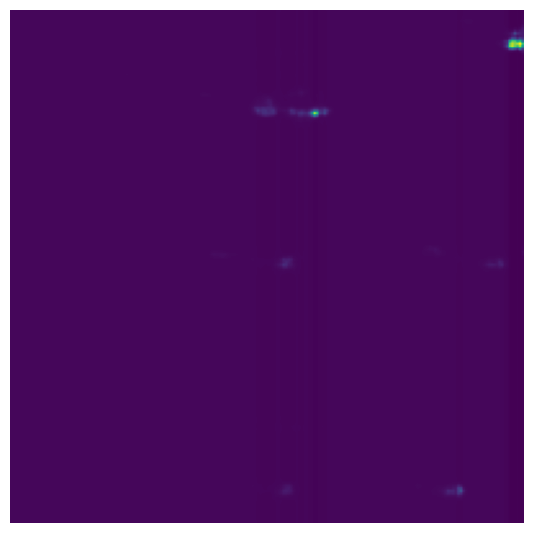

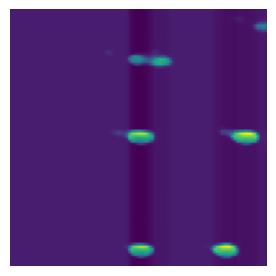

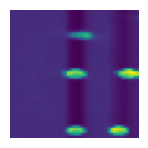

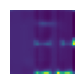

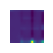

In [223]:
for idx in range(0,len(  outputs[6]['layers']['RPN_cls_logits'])):
    cls_logits = outputs[6]['layers']['RPN_cls_logits'][idx][0,0].cpu().detach().numpy()
    bbox_pred = outputs[6]['layers']['RPN_bbox_pred'][idx][0, 1].cpu().detach().numpy()

    # Apply softmax-like operation to classification scores
    cls_probs = 1 / (1 + torch.exp(-torch.Tensor(cls_logits))).cpu().detach().numpy()


    # Combine cls_probs and bbox_pred to create an informed objectness map
    objectness_map = cls_probs * (1 + bbox_pred)

    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Subtracting np.max(x) for numerical stability
        return e_x / e_x.sum(axis=0)

    # Assuming 'objectness_map' is your combined score
    combined_scores = objectness_map

    # Applying softmax
    objectness_probs = softmax(combined_scores)

    size = objectness_probs.shape[0] /30
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    
    # Plot the objectness map
    ax.imshow(objectness_probs, cmap='viridis')
    ax.set_axis_off()
    #plt.colorbar()
    #plt.title('Objectness Map (Approximation)')
    plt.savefig(f'saved_fig_{str(idx)+"-objmap"}.png')

In [224]:
 model.rpn.state_dict


<bound method Module.state_dict of RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)>

In [225]:
sizes = model.rpn.anchor_generator.sizes

In [226]:
aspect_ratios = model.rpn.anchor_generator.aspect_ratios

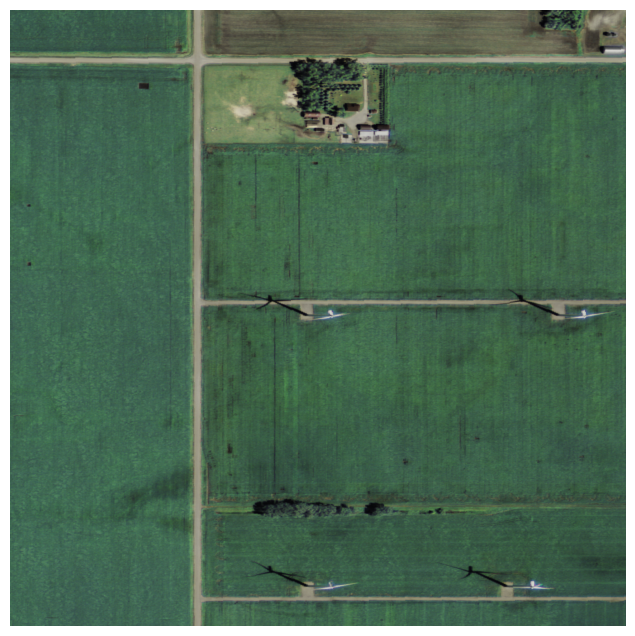

In [227]:
plot_image_with_results(outputs[6]['image'])

(1, 256, 200, 200)


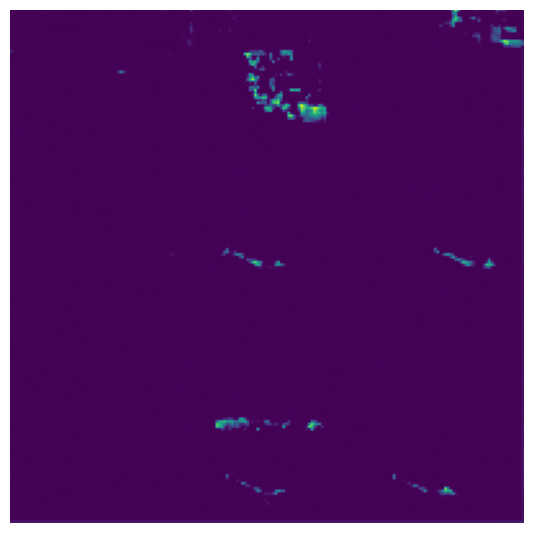

In [228]:
 print_layer(outputs[6]['layers'] , 1)

(1, 512, 100, 100)


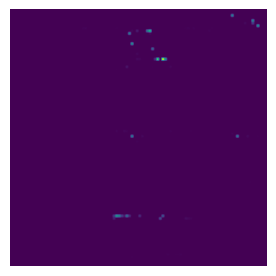

In [229]:
 print_layer(outputs[6]['layers'] , 2)

(1, 1024, 50, 50)


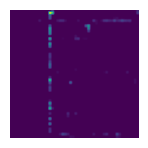

In [230]:
 print_layer(outputs[6]['layers'] , 3)

(1, 2048, 25, 25)


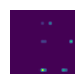

In [231]:
 print_layer(outputs[6]['layers'] , 4)

(1, 256, 200, 200)


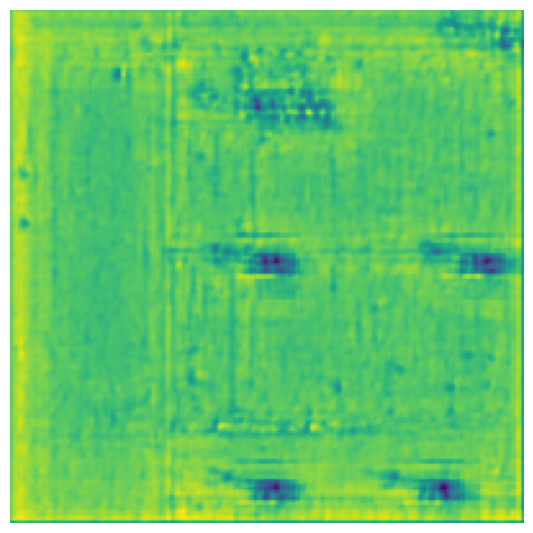

In [232]:
 print_layer(outputs[6]['layers'] , 'M5')

(1, 256, 100, 100)


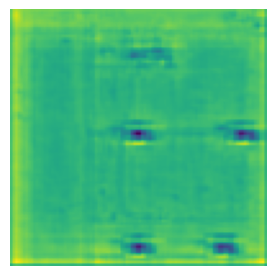

In [233]:
 print_layer(outputs[6]['layers'] , 'M4')

(1, 256, 50, 50)


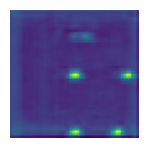

In [234]:
 print_layer(outputs[6]['layers'] , 'M3')

(1, 256, 25, 25)


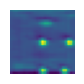

In [235]:
 print_layer(outputs[6]['layers'] , 'M2')

(1, 256, 200, 200)


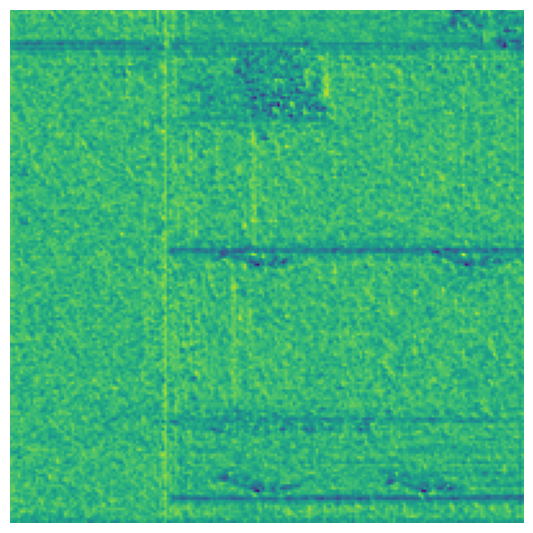

In [236]:
 print_layer(outputs[6]['layers'] , 'P2')

(1, 256, 100, 100)


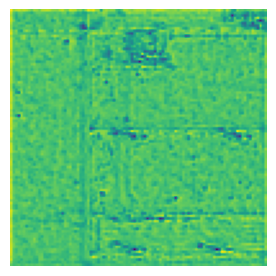

In [237]:
 print_layer(outputs[6]['layers'] , 'P3')

(1, 256, 50, 50)


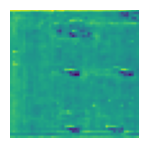

In [238]:
 print_layer(outputs[6]['layers'] , 'P4')

(1, 256, 25, 25)


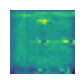

In [239]:
 print_layer(outputs[6]['layers'] , 'P5')

In [242]:
def print_model_output(outputs, idx, detection_threshold):
        #PRINTING RESULT ON THE FLY
        
        sample = outputs[idx]['image'].permute(1,2,0).cpu().numpy()
        boxes = outputs[idx]['model_output']['boxes'].data.cpu().numpy()
        scores = outputs[idx]['model_output']['scores'].data.cpu().numpy()
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        for idx, box in enumerate(boxes):
            sample = cv2.rectangle(sample.copy(),
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (220, 0, 0), 2)
            sample = cv2.putText(sample, str(scores[idx]), (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (220, 0, 0), 2)

        ax.set_axis_off()
        ax.imshow(sample)

[11/14/23 15:16:20] WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=632665;file:///home/persepolis/prj/fp/un-wind/un-wind/lib/python3.9/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=915516;file:///home/persepolis/prj/fp/un-wind/un-wind/lib/python3.9/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

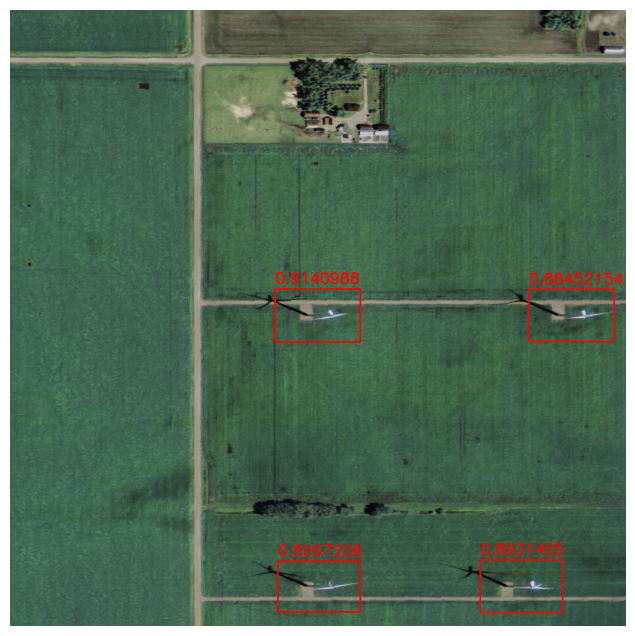

In [243]:
print_model_output(outputs, 6, 0.5)